# Модели ML

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/expanded_data_with_OSM.csv', sep = ',')
df_target = pd.read_csv('../data/train.csv', sep = ',')

df = df.merge(df_target[['id', 'target']], how='left', on='id')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8345 entries, 0 to 8344
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               8345 non-null   float64
 1   atm_group                        8345 non-null   float64
 2   address                          8345 non-null   object 
 3   address_rus                      8345 non-null   object 
 4   lat                              8345 non-null   float64
 5   lng                              8345 non-null   float64
 6   test_train_flag                  8345 non-null   object 
 7   geometry                         8345 non-null   object 
 8   distance_to_fast_food            7627 non-null   float64
 9   distance_to_clothes              7656 non-null   float64
 10  distance_to_vending_parking      2006 non-null   float64
 11  distance_to_cafe                 8039 non-null   float64
 12  distance_to_pharmacy

### Заполняем пропуски максимальными значениями

In [4]:
dff = pd.DataFrame(df.isna().sum()/len(df)).reset_index()
dff = dff[dff[0] > 0]

for col in dff[dff[0] > 0]['index']:
    if col != 'regions':
        df[col] = df[col].fillna(df[col].max())

df['regions'].replace(np.nan, 'Southern Federal District', inplace=True)

OneHotEncoding для категориальных фичей

In [5]:
df = df[df['test_train_flag'] == 'train']

df['atm_group'] = df['atm_group'].astype(int)
df = pd.get_dummies(df, columns=['atm_group'], drop_first=True) 
df = df.iloc[:, 7:]
df.drop(columns=['cities'], inplace=True)
X = pd.get_dummies(df, drop_first=True) 

y = X['target'].reset_index(drop=True)
X = X.loc[:, X.columns != 'target'].reset_index(drop=True)

## Модели

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error as MSE, mean_absolute_percentage_error as MAPE
from sklearn.preprocessing import StandardScaler
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_regression, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

### Разбиваем на train и test

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Стандартизация признаков

In [8]:
normalizer = StandardScaler()
X_real_norm_np = normalizer.fit_transform(X_train)
X_train = pd.DataFrame(data=X_real_norm_np)

normalizer = StandardScaler()
X_real_norm_np = normalizer.fit_transform(X_test)
X_test = pd.DataFrame(data=X_real_norm_np)

### Linear Regression

In [9]:
lr = LinearRegression()

lr.fit(X_train, y_train)

lr_train = lr.predict(X_train)
lr_test = lr.predict(X_test)

lr_r2_train = r2_score(y_train, lr_train)
lr_mse_train = MSE(y_train, lr_train)
lr_rmse_train = MSE(y_train, lr_train, squared=False)
lr_mape_train = MAPE(y_train, lr_train)

lr_r2_test = r2_score(y_test, lr_test)
lr_mse_test = MSE(y_test, lr_test)
lr_rmse_test = MSE(y_test, lr_test, squared=False)
lr_mape_test = MAPE(y_test, lr_test)

print(f"TRAIN: R2: {lr_r2_train}, MSE: {lr_mse_train}, \
RMSE: {lr_rmse_train}, MAPE: {lr_mape_train}\n")
print(f"TEST: R2: {lr_r2_test}, MSE: {lr_mse_test }, \
RMSE: {lr_rmse_test }, MAPE: {lr_mape_test}")


TRAIN: R2: 0.7228256875170356, MSE: 0.0020578777300692443, RMSE: 0.04536383725027287, MAPE: 3.1879526666214066

TEST: R2: -7.813579346650198e+18, MSE: 5.825659295005926e+16, RMSE: 241364025.79932922, MAPE: 7864994950.833308


### Ridge (L2-регуляризация)

In [10]:
ridge = Ridge()

ridge.fit(X_train, y_train)

ridge_train = ridge.predict(X_train)
ridge_test = ridge.predict(X_test)

ridge_r2_train = r2_score(y_train, ridge_train)
ridge_mse_train = MSE(y_train, ridge_train)
ridge_rmse_train = MSE(y_train, ridge_train, squared=False)
ridge_mape_train = MAPE(y_train, ridge_train)

ridge_r2_test = r2_score(y_test, ridge_test)
ridge_mse_test = MSE(y_test, ridge_test)
ridge_rmse_test = MSE(y_test, ridge_test, squared=False)
ridge_mape_test = MAPE(y_test, ridge_test)

print(f"TRAIN: R2: {ridge_r2_train}, MSE: {ridge_mse_train}, \
RMSE: {ridge_rmse_train}, MAPE: {ridge_mape_train}\n")
print(f"TEST: R2: {ridge_r2_test}, MSE: {ridge_mse_test}, \
RMSE: {ridge_rmse_test}, MAPE: {ridge_mape_test}")

# model.coef_

TRAIN: R2: 0.7228252698746593, MSE: 0.0020578808308506173, RMSE: 0.045363871427057646, MAPE: 3.1875328243215755

TEST: R2: 0.7046131570910739, MSE: 0.0022023493083903785, RMSE: 0.04692919462754905, MAPE: 1.9758881358670823


### ElasticNet с GridSearchCV

In [11]:
params = {'alpha': np.arange(1, 10, 1), 'l1_ratio': np.arange(0, 1.1, 0.1)}
en = GridSearchCV(ElasticNet(), param_grid=params, cv=10, n_jobs=-1)

en.fit(X_train, y_train)

en_train = en.predict(X_train)
en_test = en.predict(X_test)

en_r2_train = r2_score(y_train, en_train)
en_mse_train = MSE(y_train, en_train)
en_rmse_train = MSE(y_train, en_train, squared=False)
en_mape_train = MAPE(y_train, en_train)

en_r2_test = r2_score(y_test, en_test)
en_mse_test = MSE(y_test, en_test)
en_rmse_test = MSE(y_test, en_test, squared=False)
en_mape_test = MAPE(y_test, en_test)

print(f"TRAIN: R2: {en_r2_train}, MSE: {en_mse_train}, \
RMSE: {en_rmse_train}, MAPE: {en_mape_train}\n")
print(f"TEST: R2: {en_r2_test}, MSE: {en_mse_train}, \
RMSE: {en_rmse_test}, MAPE: {en_mape_test}")

TRAIN: R2: 0.5939666454767315, MSE: 0.003014590314858632, RMSE: 0.05490528494469937, MAPE: 2.3414475588160992

TEST: R2: 0.568752631559521, MSE: 0.003014590314858632, RMSE: 0.056703616229667346, MAPE: 1.5474032843455687


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.48551455898146, tolerance: 0.003316519390946195
  model = cd_fast.enet_coordinate_descent(


### Отбор признаков для линейных моделей
посмотрим, в какую сторону повлияет выбрасывание нескольких признаков

In [12]:
params = {'alpha': np.arange(1, 10, 1), 'l1_ratio': np.arange(0, 1.1, 0.1)}

pipe = Pipeline([
    ('scaler_', StandardScaler()),
    ('selector_', SelectKBest(score_func=f_regression, k=100)), 
    ('model_', Ridge())]
)

cv_res = cross_validate(pipe, X, y, cv=5, scoring='r2', return_train_score=True)
cv_res['test_score'].mean()

C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


0.7040015173611543

In [13]:
params = {'alpha': np.arange(1, 10, 1), 'l1_ratio': np.arange(0, 1.1, 0.1)}

pipe = Pipeline([
    ('scaler_', StandardScaler()),
    ('selector_', SelectKBest(score_func=f_regression, k=50)), 
    ('model_', Ridge())]
)

cv_res = cross_validate(pipe, X, y, cv=5, scoring='r2', return_train_score=True)
cv_res['test_score'].mean()

C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


0.6987174814424961

Отбор признаков дает результат хуже => оставляем все признаки

### Дерево решений

In [14]:
tree = DecisionTreeRegressor()

tree.fit(X_train, y_train)

tree_train = tree.predict(X_train)
tree_test = tree.predict(X_test)

tree_r2_train = r2_score(y_train, tree_train)
tree_mse_train = MSE(y_train, tree_train)
tree_rmse_train = MSE(y_train, tree_train, squared=False)
tree_mape_train = MAPE(y_train, tree_train)

tree_r2_test = r2_score(y_test, tree_test)
tree_mse_test = MSE(y_test, tree_test)
tree_rmse_test = MSE(y_test, tree_test, squared=False)
tree_mape_test = MAPE(y_test, tree_test)


print(f"TRAIN: R2: {tree_r2_train}, MSE: {tree_mse_train}, \
RMSE: {tree_rmse_train}, MAPE: {tree_mape_train}\n")
print(f"TEST: R2: {tree_r2_test}, MSE: {tree_mse_test}, \
RMSE: {tree_rmse_test}, MAPE: {tree_mape_test}")

TRAIN: R2: 0.98784588750499, MSE: 9.02380787316815e-05, RMSE: 0.009499372544104242, MAPE: 0.4836188356413414

TEST: R2: 0.45624832283110717, MSE: 0.004054111274408532, RMSE: 0.06367190333583984, MAPE: 2.907765147479821


### Дерево решений с GridSearchCV

In [15]:
params = {'max_depth' : np.arange(3, 10, 1),
          'max_features' : ["auto", "sqrt", "log2"],
          'min_samples_leaf': np.arange(3, 8, 1)}

gs_tree = GridSearchCV(DecisionTreeRegressor(), params, cv=5, scoring='r2')

gs_tree.fit(X_train, y_train)

gs_tree_train = gs_tree.predict(X_train)
gs_tree_test = gs_tree.predict(X_test)

gs_tree_r2_train = r2_score(y_train, gs_tree_train)
gs_tree_mse_train = MSE(y_train, gs_tree_train)
gs_tree_rmse_train = MSE(y_train, gs_tree_train, squared=False)
gs_tree_mape_train = MAPE(y_train, gs_tree_train)

gs_tree_r2_test = r2_score(y_test, gs_tree_test)
gs_tree_mse_test = MSE(y_test, gs_tree_test)
gs_tree_rmse_test = MSE(y_test, gs_tree_test, squared=False)
gs_tree_mape_test = MAPE(y_test, gs_tree_test)

print(f"TRAIN: R2: {gs_tree_r2_train}, MSE: {gs_tree_mse_train}, \
RMSE: {gs_tree_rmse_train}, MAPE: {gs_tree_mape_train}\n")
print(f"TEST: R2: {gs_tree_r2_test}, MSE: {gs_tree_mse_test}, \
RMSE: {gs_tree_rmse_test}, MAPE: {gs_tree_mape_test}")

TRAIN: R2: 0.7083483277641847, MSE: 0.0021653647333153463, RMSE: 0.046533479703492475, MAPE: 3.342102870330768

TEST: R2: 0.6841914688932698, MSE: 0.0023546096136757583, RMSE: 0.04852431981672446, MAPE: 2.098412704456037


### Метод ближайших соседей

In [16]:
knn = KNeighborsRegressor(n_neighbors=10) #лучший результат достигается с 10-ю соседями
knn.fit(X_train, y_train)

knn_train = knn.predict(X_train)
knn_test = knn.predict(X_test)

knn_r2_train = r2_score(y_train, knn_train)
knn_mse_train = MSE(y_train, knn_train)
knn_rmse_train = MSE(y_train, knn_train, squared=False)
knn_mape_train = MAPE(y_train, knn_train)

knn_r2_test = r2_score(y_test, knn_test)
knn_mse_test = MSE(y_test, knn_test)
knn_rmse_test = MSE(y_test, knn_test, squared=False)
knn_mape_test = MAPE(y_test, knn_test)

print(f"TRAIN: R2: {knn_r2_train}, MSE: {knn_mse_train}, \
RMSE: {knn_rmse_train}, MAPE: {knn_mape_train}\n")
print(f"TEST: R2: {knn_r2_test}, MSE: {knn_mse_train}, \
RMSE: {knn_rmse_test}, MAPE: {knn_mape_test}")


TRAIN: R2: 0.575098160074728, MSE: 0.0031546791837046805, RMSE: 0.05616653081421961, MAPE: 2.430342829800941

TEST: R2: 0.4655563425095737, MSE: 0.0031546791837046805, RMSE: 0.06312457851396132, MAPE: 2.2412103910504095


### Метод опорных векторов

In [17]:
svr = SVR()
svr.fit(X_train, y_train)

svr_train = svr.predict(X_train)
svr_test = svr.predict(X_test)

svr_r2_train = r2_score(y_train, svr_train)
svr_mse_train = MSE(y_train, svr_train)
svr_rmse_train = MSE(y_train, svr_train, squared=False)
svr_mape_train = MAPE(y_train, svr_train)

svr_r2_test = r2_score(y_test, svr_test)
svr_mse_test = MSE(y_test, svr_test)
svr_rmse_test = MSE(y_test, svr_test, squared=False)
svr_mape_test = MAPE(y_test, svr_test)

print(f"TRAIN: R2: {svr_r2_train}, MSE: {svr_mse_train}, \
      RMSE: {svr_rmse_train}, MAPE: {svr_mape_train}")
print(f"TEST: R2: {svr_r2_test}, MSE: {svr_mse_train}, \
          RMSE: {svr_rmse_test}, MAPE: {svr_mape_test}")


TRAIN: R2: 0.6030266980308299, MSE: 0.002947324051194744,       RMSE: 0.05428926276156957, MAPE: 2.7464638973869517
TEST: R2: 0.5454453415056573, MSE: 0.002947324051194744,           RMSE: 0.058215761689008216, MAPE: 1.7914532728538346


### Catboost

In [18]:
from catboost import CatBoostRegressor, Pool

In [19]:
df = pd.read_csv('../data/expanded_data_with_OSM.csv', sep = ',')
df_target = pd.read_csv('../data/train.csv', sep = ',')

df = df.merge(df_target[['id', 'target']], how='left', on='id')

In [20]:
dff = pd.DataFrame(df.isna().sum()/len(df)).reset_index()
dff = dff[dff[0] > 0]

for col in dff[dff[0] > 0]['index']:
    if col != 'regions':
        df[col] = df[col].fillna(df[col].max())

df['regions'].replace(np.nan, 'Southern Federal District', inplace=True)

df = df[df['test_train_flag'] == 'train']

df['atm_group'] = df['atm_group'].astype(int)
# df = pd.get_dummies(df, columns=['atm_group'], drop_first=True) 
# df = df.iloc[:, 7:]
# df.drop(columns=['cities'], inplace=True)

X = df.drop(['target', 'test_train_flag'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
categorical_features = ['cities', 'regions', 'states', 'atm_group', 'address', 'address_rus', 'geometry']
ignored_features = ['address', 'address_rus', 'geometry']

clf_params = {
    'cat_features': categorical_features,
    'ignored_features': ignored_features,
    'bagging_temperature': 1,
    'custom_metric': ['RMSE'],
    'score_function': 'L2',
#     'use_best_model': True,
    'iterations': 200
}

train_pool = Pool(X_train, y_train, cat_features=categorical_features, feature_names=list(X_train.columns))
test_pool = Pool(X_test, y_test, cat_features=categorical_features, feature_names=list(X_test.columns))

catboost = CatBoostRegressor(**clf_params, loss_function='RMSE', eval_metric='R2')
cb = catboost.fit(train_pool, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
cb_train = cb.predict(X_train) 
cb_test = cb.predict(X_test)

cb_r2_train = r2_score(y_train, cb_train)
cb_mse_train = MSE(y_train, cb_train)
cb_rmse_train = MSE(y_train, cb_train, squared=False)
cb_mape_train = MAPE(y_train, cb_train)

cb_r2_test = r2_score(y_test, cb_test)
cb_mse_test = MSE(y_test, cb_test)
cb_rmse_test = MSE(y_test, cb_test, squared=False)
cb_mape_test = MAPE(y_test, cb_test)

print(f"TRAIN: R2: {cb_r2_train}, MSE: {cb_mse_train}, \
      RMSE: {cb_rmse_train}, MAPE: {cb_mape_train}")
print(f"TEST: R2: {cb_r2_test}, MSE: {cb_mse_train}, \
          RMSE: {cb_rmse_test}, MAPE: {cb_mape_test}")


TRAIN: R2: 0.8944723192544566, MSE: 0.0007834891414241641,       RMSE: 0.027990876038883887, MAPE: 1.9585466607653037
TEST: R2: 0.7434217674720536, MSE: 0.0007834891414241641,           RMSE: 0.0437378501347646, MAPE: 1.9694655076764538


Посмотрим на важность признаков

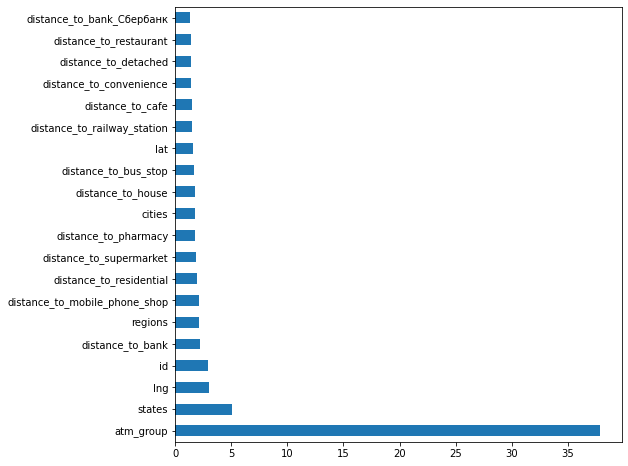

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
feat_importances = pd.Series(cb.feature_importances_, index=X_train.columns).nlargest(20).plot(kind='barh')